# Prediccion del precio de las viviendas mediante regresion lineal

En este script de realizara la prediccion mediantes metodos de regresion

# Librerias

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error , r2_score , mean_absolute_error , explained_variance_score
import warnings
warnings.filterwarnings("ignore")

# Datos

In [140]:
dfp=pd.read_csv(r'C:\Users\Juan Guzman\pviviendas\Data\dfanalisis')
dfp.head()

,tipo,precio,area,habitaciones,banos,garajes,balcon,trasn. publico,estrato,antiguedad,...,zonas verdes,supermercado o cc,instalacion de gas,parqueadero visitantes,colegios / universidades,parques cercanos,zona residencial,closet,municipio,tipo_propiedad
0,0,1380000000,320.00,5,6.0,2,1.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rionegro,casa
1,1,496122600,91.97,3,3.0,1,1.0,1.0,3.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,rionegro,apartamento
2,0,570000000,150.00,3,3.0,1,1.0,1.0,5.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,san antonio de pereira,casa
3,0,290000000,106.00,3,3.0,1,0.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,marinilla,casa
4,1,360002000,73.37,3,3.0,0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,rionegro,apartamento


# Procesamiento de los datos


Primero dividiremos la variable objetivo que seria el precio de las variables explicativas que serian todas las demas

In [141]:
y = dfp['precio']
X_numeric = dfp.drop(['precio','municipio','tipo_propiedad'],axis=1)
X_categoric = dfp[['municipio','tipo_propiedad']]


## Procesamiento de variables numericas

para la regresión lineal múltiple, se recomienda que las variables predictoras y la variable objetivo tengan una distribución normal y que la relación entre ellas sea lineal. Si estas condiciones no se cumplen, se pueden aplicar transformaciones a las variables para mejorar la precisión del modelo.

Debido a que las distribuciones de las variables tienen comportamiento muy variados unas de otras se optara por estandarizar la variable lo que significa centrar  la variable en $0$ y con una desviación estándar de $1$:

$$X^{\prime} = \frac{X - \mu}{\sigma}$$


In [142]:
scaler = StandardScaler() # declaramos el transformador
X_numeric_est = scaler.fit_transform(X_numeric)

## Procesamiento de variables categoricas

In [143]:
print(np.unique(X_categoric))

['apartaestudio' 'apartamento' 'casa' 'el carmen de viboral' 'el retiro'
 'finca' 'guarne' 'la ceja' 'llanogrande' 'marinilla' 'rionegro'
 'san antonio de pereira' 'santuario']


haremos el procesamiento mediante OneHotEncoder, el cual se asemeja al tratamiento de una variable dummi, es decir, para cada categoria se le asignara 1 si corresponde a esa categoria y 0 para las demas

In [144]:
enc = OneHotEncoder(sparse=False)
X_categoric_onehot = enc.fit_transform(X_categoric)
X_categoric.shape , X_categoric_onehot.shape

((2144, 2), (2144, 13))

Podemos observar que se teniamos 13 categorias en las dos columnas

Ahora procederemos a unir los dos conjuntos de datos en la variable X

In [145]:
X = np.concatenate((X_numeric_est,X_categoric_onehot),axis=1)
dfp.shape , X.shape

((2144, 23), (2144, 33))

# Entrenamiento del modelo

Para este caso dividiremos los datos de la siguiente manera:
* 60% entrenamiento
* 20% test
* 20%validacion

Debido a que la regreison lineal no permite modificar muchos hiperparametros no entramos en la necesidad de utilizar un porcentaje de los datos para validar.
Con el fin de realizar un buen entrenamiento del algoritmo y mejorar su capacidad predictiva

In [146]:
# Primera división en train y test (80% y 20% respectivamente)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Segunda división en train y validación (60% y 20% respectivamente)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1234)

# Imprimir las dimensiones de cada conjunto
print(f"Conjunto de entrenamiento: {X_train.shape[0]}, {y_train.shape[0]}, en porcentaje correspone a {round(((X_train.shape[0]/X.shape[0])*100),0)} del total de la muestra")
print(f"Conjunto de validación: {X_val.shape[0]}, {y_val.shape[0]}, en porcentaje correspone a {round(((X_val.shape[0]/X.shape[0])*100),0)} del total de la muestra")
print(f"Conjunto de prueba: {X_test.shape[0]}, {y_test.shape[0]}, en porcentaje correspone a {round(((X_test.shape[0]/X.shape[0])*100),0)} del total de la muestra")


Conjunto de entrenamiento: 1286, 1286, en porcentaje correspone a 60.0 del total de la muestra
Conjunto de validación: 429, 429, en porcentaje correspone a 20.0 del total de la muestra
Conjunto de prueba: 429, 429, en porcentaje correspone a 20.0 del total de la muestra


# Modelo

## Regresion lineal 

In [147]:
linear = LinearRegression()
linear.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

## Regresion Ridge

In [148]:
ridge = Ridge(random_state=42)
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': 42,
 'solver': 'auto',
 'tol': 0.001}

## Regresion Lasso

In [149]:
lasso = Lasso(random_state=42)
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

# Validacion cruzada

## Regresion lineal

In [150]:
param_grid_linear = {'fit_intercept': [True, False],
                    'normalize': [True, False],
                    'copy_X': [True, False],
                    'positive': [True, False]
}
param_grid_linear

{'fit_intercept': [True, False],
 'normalize': [True, False],
 'copy_X': [True, False],
 'positive': [True, False]}

In [151]:
gridlinear = GridSearchCV(linear, param_grid_linear, cv=5) # cv son las divisiones de la validacion cruzada

In [152]:
# entrenamiento del modelo
gridlinear.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'positive': [True, False]})

In [153]:
print(gridlinear.best_params_)
print(gridlinear.best_estimator_)

{'copy_X': True, 'fit_intercept': False, 'normalize': True, 'positive': False}
LinearRegression(fit_intercept=False, normalize=True)


## Regresion Ridge

sus parametros son:
* alpha(float):  parametro de regularicacion que controla la fuerza de la penalizacion de la norma L2. el valor predeterminado es 1.0. el alpha= 0 es lo mismo que una regreison lineal
* fit_intercept(bool): Ya sea para ajustar la intersección para este modelo. Si se establece en falso, no se utilizará intercepción en los cálculos
* normalize(bool): indica si se debe normalizar las variables de entrada
* copy_X(bool): indica si se deben copiar los datos de entrada
* max_iter(int): Número máximo de iteraciones para el solucionador de gradiente conjugado
* tol(float): Precisión de la solución
* Solver(): metodo de solucion para el problema de optimizacion. Los valores posibles son auto,svd,cholesky,lsqr o sparse_cg

In [154]:
param_grid_ridge = {
    'alpha': [0.1,1.0,10.0],
    'fit_intercept': [True,False],
    'normalize': [True,False],
    'copy_X': [True,False],
    'max_iter':np.linspace(100,1000,10),
    'tol':np.linspace(1e-4,1e-1,10),
    'solver':['auto','svd','cholesky','lsqr','sparse_cg'],
}

In [155]:
gridridge = GridSearchCV(ridge, param_grid_ridge, cv=5)

In [156]:
# entrenamiento del modelo
gridridge.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=42),
             param_grid={'alpha': [0.1, 1.0, 10.0], 'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'max_iter': array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.]),
                         'normalize': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg'],
                         'tol': array([0.0001, 0.0112, 0.0223, 0.0334, 0.0445, 0.0556, 0.0667, 0.0778,
       0.0889, 0.1   ])})

In [157]:
print(gridridge.best_params_)
print(gridridge.best_estimator_)

{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 100.0, 'normalize': True, 'solver': 'lsqr', 'tol': 0.0001}
Ridge(alpha=0.1, max_iter=100.0, normalize=True, random_state=42, solver='lsqr',
      tol=0.0001)


## Regresion Lasso

sus parametros son:
* alpha(float):  Constante que multiplica el término L1, controlando la fuerza de regularización. alphadebe ser un flotante no negativo, es decir, en 0, inf. el alpha= 0 es lo mismo que una regreison lineal
* fit_intercept(bool): Ya sea para ajustar la intersección para este modelo. Si se establece en falso, no se utilizará intercepción en los cálculos
* normalize(bool): indica si se debe normalizar las variables de entrada
* copy_X(bool): indica si se deben copiar los datos de entrada
* max_iter(int): Número máximo de iteraciones
* tol(float): Precisión de la solución
* precompute(bool): Ya sea para usar una matriz Gram precalculada para acelerar los cálculos
* warm_start(bool): Cuando se establece en True, reutiliza la solución de la llamada anterior para que se ajuste como inicialización; de lo contrario, simplemente borra la solución anterior
* selection(ciclico, aleatorio): Si se establece en 'aleatorio', se actualiza un coeficiente aleatorio en cada iteración en lugar de recorrer las funciones de forma secuencial de forma predeterminada

In [158]:
param_grid_lasso = {
   'alpha': [0.1, 1.0, 10.0],
   'fit_intercept': [True, False],
   'normalize': [True, False],
   'copy_X': [True, False],
   'max_iter': np.linspace(100,1000,10),
   'tol': np.linspace(1e-4,1e-1,10),
   'selection': ['cyclic', 'random']
}


In [159]:
gridlasso = GridSearchCV(lasso, param_grid_lasso, cv=5)

In [160]:
# entrenamiento del modelo
gridlasso.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(random_state=42),
             param_grid={'alpha': [0.1, 1.0, 10.0], 'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'max_iter': array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.]),
                         'normalize': [True, False],
                         'selection': ['cyclic', 'random'],
                         'tol': array([0.0001, 0.0112, 0.0223, 0.0334, 0.0445, 0.0556, 0.0667, 0.0778,
       0.0889, 0.1   ])})

In [161]:
print(gridlasso.best_params_)
print(gridlasso.best_estimator_)

{'alpha': 10.0, 'copy_X': True, 'fit_intercept': False, 'max_iter': 1000.0, 'normalize': True, 'selection': 'cyclic', 'tol': 0.0001}
Lasso(alpha=10.0, fit_intercept=False, max_iter=1000.0, normalize=True,
      random_state=42)


GridSearchCV.cv_results_. Para visualizarlo mejor convertimos ese diccionario a un DataFrame de Pandas

# Evaluacion del modelo

In [162]:
def metrics(model, y_true, X_val, model_name):
    y_est = model.predict(X_val)
    r2 = r2_score(y_true, y_est)
    mse = mean_squared_error(y_true, y_est)
    absolutemse = mean_absolute_error(y_true, y_est)
    rmse = np.sqrt(mean_squared_error(y_true, y_est))
    ev = explained_variance_score(y_true, y_est)
    results = {'R2': round(r2, 4), 'MSE': round(mse, 4), 'RMSE': round(rmse, 4), 'AbsoluteMSE': round(absolutemse, 4), 'ExplainedVariance': round(ev, 4)}
    df = pd.DataFrame.from_dict(results, orient='index', columns=[model_name]).transpose()
    df.index.name = 'model_name'
    return df


In [163]:
metric_linear = metrics(gridlinear,y_val,X_val,'linear')
metric_lasso = metrics(gridlasso,y_val,X_val,'lasso')
metric_ridge =metrics(gridridge,y_val,X_val,'ridge')
dfmetrics = pd.concat([metric_linear,metric_lasso,metric_ridge])
dfmetrics

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
linear,0.6384,8.500635e+16,2.915585e+08,2.052756e+08,0.6399
lasso,0.6384,8.500640e+16,2.915586e+08,2.052757e+08,0.6399
ridge,0.6419,8.419710e+16,2.901674e+08,2.023607e+08,0.6430


In [164]:
dfmetrics.idxmin()

R2                   linear
MSE                   ridge
RMSE                  ridge
AbsoluteMSE           ridge
ExplainedVariance    linear
dtype: object

In [165]:
dfmetrics.idxmax()

R2                   ridge
MSE                  lasso
RMSE                 lasso
AbsoluteMSE          lasso
ExplainedVariance    ridge
dtype: object

En base a las metricas se espera escogio el modelo Ridge, debido a que tiene el R2 y la Varianza explicada mas alta, ademas de tener el MSE,RMSE y absoluteMSE mas bajo

ahora ya podemos visualizar y entrenamos el modelo tambien con los datos de validacion

# Modelo final usando datos de entrenamiento y validacion

Se procedera a utilizar el modelo ridge con los parametros obtenidos mediante cross validation, ademas de integrar los datos de entreno y validacion para probarlos sobre los datos de prueba

In [166]:
# Unimos los datos de train y validation
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
print(X_train_val.shape)
print(y_train_val.shape)


(1715, 33)
(1715,)


In [167]:
# modelo lineal
ridge = Ridge(alpha=0.1, max_iter=100.0, normalize=True, random_state=42, solver='lsqr',tol=0.0001)
ridge.fit(X_train_val,y_train_val)

Ridge(alpha=0.1, max_iter=100.0, normalize=True, random_state=42, solver='lsqr',
      tol=0.0001)

In [168]:
metric_ridge_test = metrics(ridge,y_test,X_test,'ridgenew')
metric_ridge_test

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
ridgenew,0.6388,1.050614e+17,3.241318e+08,2.188530e+08,0.6417


In [169]:
# comparamos las metricas en validacion y en test
rige_comparacion = pd.concat([metric_ridge_test,metric_ridge])
# los valores de la primera fila corresponden a el modelo probado con los datos de test
rige_comparacion

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
ridgenew,0.6388,1.050614e+17,3.241318e+08,2.188530e+08,0.6417
ridge,0.6419,8.419710e+16,2.901674e+08,2.023607e+08,0.6430


In [170]:
y_pred_ridge = ridge.predict(X_test)

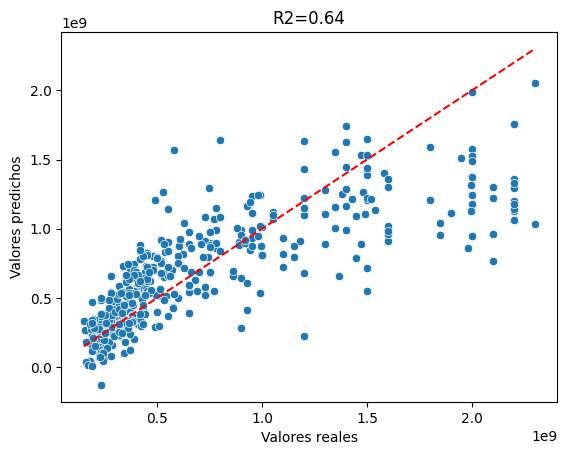

In [171]:
df_grafica_test = pd.DataFrame({'Valores reales': y_test, 'Valores predichos': y_pred_ridge})


sns.scatterplot(data=df_grafica_test, x='Valores reales', y='Valores predichos')
sns.lineplot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='r', linestyle='--')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title(f'R2={r2_score(y_test, y_pred_ridge):.2f}')
plt.show()


Esta grafica muestra los valores reales en el eje x y los valores predichos por el modelo en el eje y. La linea roja punteada representa una prediccion perfecta, es decir, en la que los valores reales y predichos coinciden. Ademas se muestra el coeficiente de determiancion R2 , que indica cuanto varian los valores predichos en funcion de los valores reales

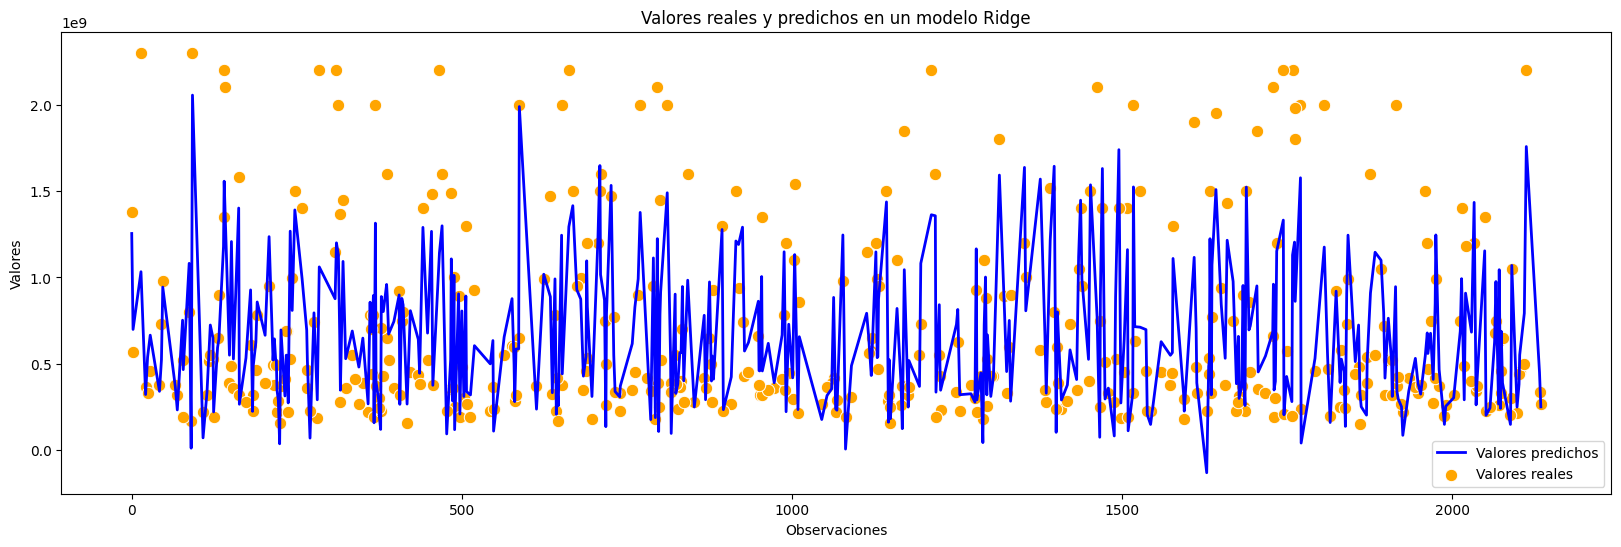

In [172]:
plt.figure(figsize=(20, 6))

sns.lineplot(x=df_grafica_test.index, y='Valores predichos', data=df_grafica_test, linewidth=2, color='blue')
sns.scatterplot(x=df_grafica_test.index, y='Valores reales', data=df_grafica_test,  s=80, color='orange')
plt.title('Valores reales y predichos en un modelo Ridge')
plt.xlabel('Observaciones')
plt.ylabel('Valores')
plt.legend(labels=['Valores predichos', 'Valores reales'])

# Conclusion - Modelos Lineales

En el análisis de los modelos lineales seleccionados, se encontró que el modelo lineal Ridge fue el que mejor explicó los datos. A través de la validación cruzada, se encontraron sus hiperparámetros, y se determinó que los mejores hiperparámetros son: alpha=0.1, max_iter=100.0, normalize=True, random_state=42, solver='lsqr', tol=0.0001.

Las métricas de evaluación de este modelo sobre los datos de validación son las siguientes:

* R2: 0.6388
* MSE: 1.050614e+17
* RMSE: 3.241318e+08
* AbsoluteMSE: 2.188530e+08
* Varianza explicada: 0.6417

Se observó que el modelo tuvo resultados moderadamente buenos tanto en la validación como en la prueba. Por lo tanto, no hay sobreajuste ni subajuste del modelo. Sin embargo, debido a que es un modelo lineal y al comportamiento de los datos, se podría hablar de un subajuste.

Aunque estas métricas fueron las mejores de los 3 modelos, no son completamente confiables. Se pueden aceptar, pero se pueden mejorar mediante el uso de otros métodos de aprendizaje automático.